## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Яковлев Дмитрий Алексеевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов (1 балл)

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 106096755.64it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38862911.08it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25240018.97it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3276664.73it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

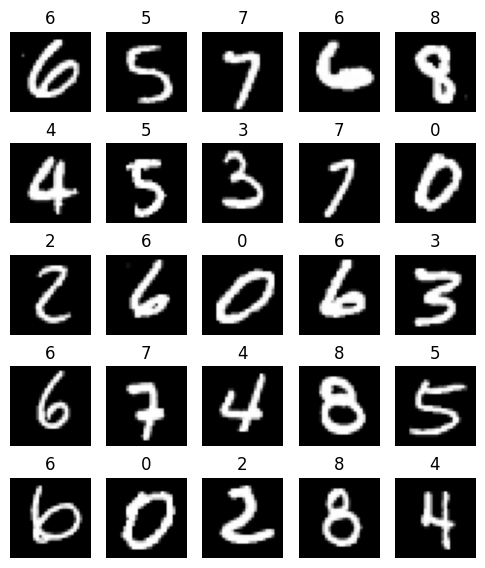

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward in', std)
    # with torch.no_grad():
    #     print('forward out', output.std().item())

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
network = nn.Sequential(layer)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward in 1.0066394805908203
backward 0.040824826806783676


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [8]:
def start_experiment(network, n_objects=100):
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [9]:
def get_network(init='normal_noise'):
    def get_std(layer, init):
        if init == 'normal_noise':
            return 0.1
        elif init == 'He':
            return np.sqrt(
                2 / (layer.in_features)
            )
        elif init == 'Xavier':
            return np.sqrt(
                2 / (layer.in_features + layer.out_features)
            )
    
    layers = []
    layer = nn.Linear(28 * 28, 500)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, get_std(layer, init))
    layers.append(layer)
    layers.append(nn.Tanh())

    for _ in range(9):
        layer = nn.Linear(500, 500)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_layer(layer, 0.0, get_std(layer, init))
        layers.append(layer)
        layers.append(nn.Tanh())
    
    layer = nn.Linear(500, 10)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, get_std(layer, init))
    layers.append(layer)

    return nn.Sequential(*layers)

In [10]:
start_experiment(get_network())

forward in 1.0066394805908203
forward in 0.8501620292663574
forward in 0.7864405512809753
forward in 0.7734254598617554
forward in 0.7671862840652466
forward in 0.7650266289710999
forward in 0.7642978429794312
forward in 0.7646777629852295
forward in 0.7654204368591309
forward in 0.7672933340072632
forward in 0.765356719493866
backward 0.040824826806783676
backward 0.01505245640873909
backward 0.014411985874176025
backward 0.013681905344128609
backward 0.014837977476418018
backward 0.016083426773548126
backward 0.01701599545776844
backward 0.01841989904642105
backward 0.021233193576335907
backward 0.023753179237246513
backward 0.022969825193285942


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [11]:
start_experiment(get_network("He"))

forward in 1.0066394805908203
forward in 0.7133963108062744
forward in 0.6234574913978577
forward in 0.589138388633728
forward in 0.5753114223480225
forward in 0.5670228600502014
forward in 0.552985668182373
forward in 0.5540679693222046
forward in 0.5519833564758301
forward in 0.5538102984428406
forward in 0.55711430311203
backward 0.040824826806783676
backward 0.015793750062584877
backward 0.016292333602905273
backward 0.016492672264575958
backward 0.01693842187523842
backward 0.01643206551671028
backward 0.015489189885556698
backward 0.015502069145441055
backward 0.015387987717986107
backward 0.013980776071548462
backward 0.01081162691116333


In [12]:
start_experiment(get_network("Xavier"))

forward in 1.0066394805908203
forward in 0.6497007608413696
forward in 0.5042341947555542
forward in 0.417622834444046
forward in 0.3621630370616913
forward in 0.3188522160053253
forward in 0.2910021245479584
forward in 0.2663584053516388
forward in 0.2521875500679016
forward in 0.2381533533334732
forward in 0.22500500082969666
backward 0.040824826806783676
backward 0.019679944962263107
backward 0.01787560060620308
backward 0.016821667551994324
backward 0.01643121801316738
backward 0.014784782193601131
backward 0.013148587197065353
backward 0.01135313417762518
backward 0.009557973593473434
backward 0.007211942691355944
backward 0.004552075173705816


<i> 1.4 Сделайте выводы по первой части </i>

$N(0,0.1)$:
* Дисперсия активаций - сходится и сохраняется около $0.7^2$
* Дисперсия градиентов - сначала убывают потом вновь возрастает $0.28^2-0.13^2-0.23^2$ достаточно стахостично

$He$:
* Дисперсия активаций - монотонно уменьшается и сохраняется около $0.55^2$
* Дисперсия градиентов - монотонно уменьшается и сохраняется около $0.01^2$ в последующем уменьшаясь до тысячных

$Xavier$:
* Дисперсия активаций - монотонно уменьшается
* Дисперсия градиентов - монотонно уменьшается и сохраняется около $0.01^2$ в последующем уменьшаясь до тысячных

### Часть 2: Dropout (1 балл)

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [13]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p
        self.helpful = nn.Parameter(torch.empty(0))

    def forward(self, x):
        with torch.no_grad():
            mask = (torch.ones(self.linear.weight.size()) * self.p)    
            if self.training:
                mask = mask.bernoulli_()
            mask = mask.data

        output = F.linear(x, self.linear.weight * mask.to(self.helpful.device), self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [14]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
cd "drive/My Drive/notebooks/NN/hw5"

/content/drive/My Drive/notebooks/NN/hw5


Epoch 9... (Train/Test) NLL: 0.127/0.077	Accuracy: 0.963/0.975


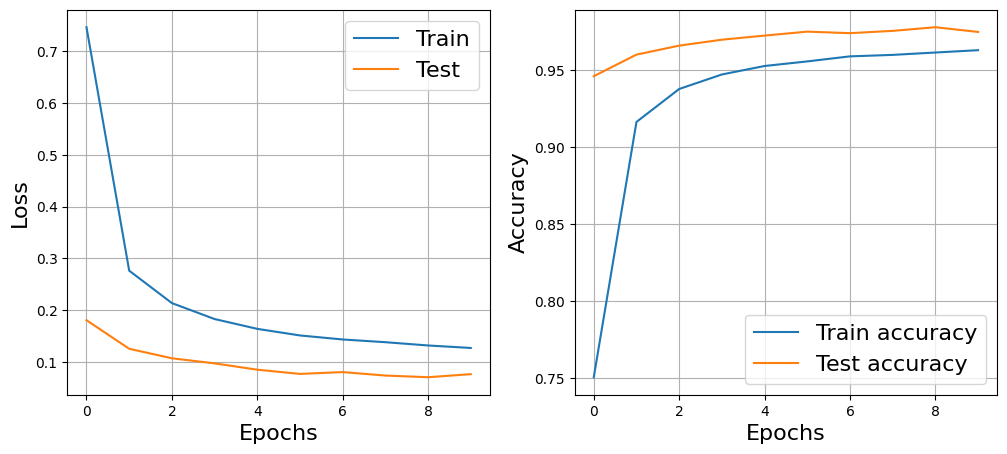

In [17]:
from train_utils import train

layers = nn.Sequential(
    nn.Linear(196, 128),
    nn.ReLU(), nn.Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(), nn.Dropout(),
    nn.Linear(128, 10),
)

network = TestNetwork(layers)

train_loss_1, test_loss_1, train_score_1, test_score_1 = train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.174/0.099	Accuracy: 0.947/0.969


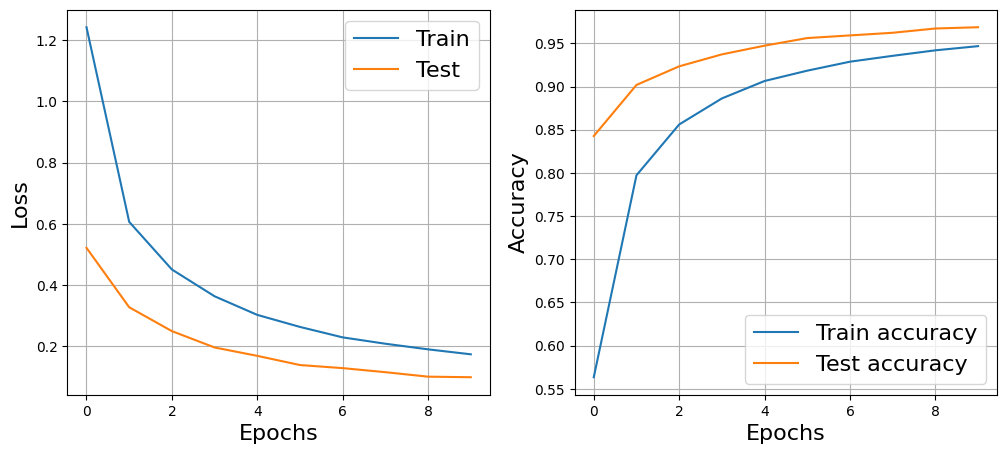

In [18]:
layers = nn.Sequential(
    DropConnect(196, 128), 
    nn.ReLU(),
    DropConnect(128, 128), 
    nn.ReLU(),
    DropConnect(128, 10)
)

network = TestNetwork(layers)

train_loss_2, test_loss_2, train_score_2, test_score_2 = train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по второй части. </i>

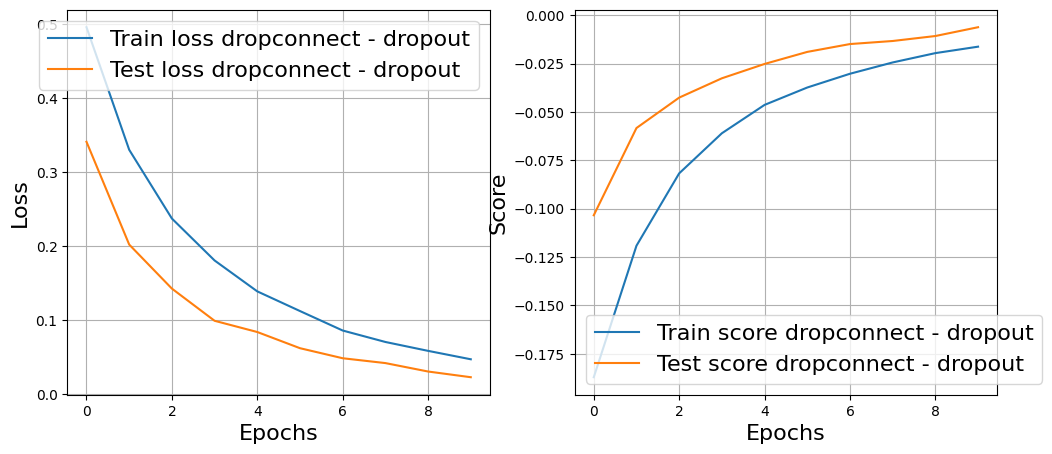

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.array(train_loss_2) - np.array(train_loss_1), label='Train loss dropconnect - dropout')
plt.plot(np.array(test_loss_2) - np.array(test_loss_1), label='Test loss dropconnect - dropout')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.array(train_score_2) - np.array(train_score_1), label='Train score dropconnect - dropout')
plt.plot(np.array(test_score_2) - np.array(test_score_1), label='Test score dropconnect - dropout')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

$DropConnect\ vs\ DropOut$
* DropConnect - Loss : 0.174/0.099, Score : 0.947/0.969
* DropOut - Loss : 0.127/0.077, Score : 0.963/0.975
* По графикам видно при DropConnect функционал качества чуть медленее сходится, и значение метрики также чуть хуже

### Часть 3: Batch Normalization (3 балла)

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [20]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim, eps=1e-8):
        super(LayerNormalization, self).__init__()
    
        self.gamma = nn.Parameter(torch.ones(input_dim))
        self.beta = nn.Parameter(torch.zeros(input_dim))
        self.eps = eps

    def forward(self, x):
        x_norm = (
            (x - x.mean(dim=-1, keepdim=True)) 
            /
            (x.std(dim=-1, keepdim=True, unbiased=False) + self.eps)
        )
        output = self.gamma * x_norm + self.beta

        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.030/0.064	Accuracy: 0.990/0.980


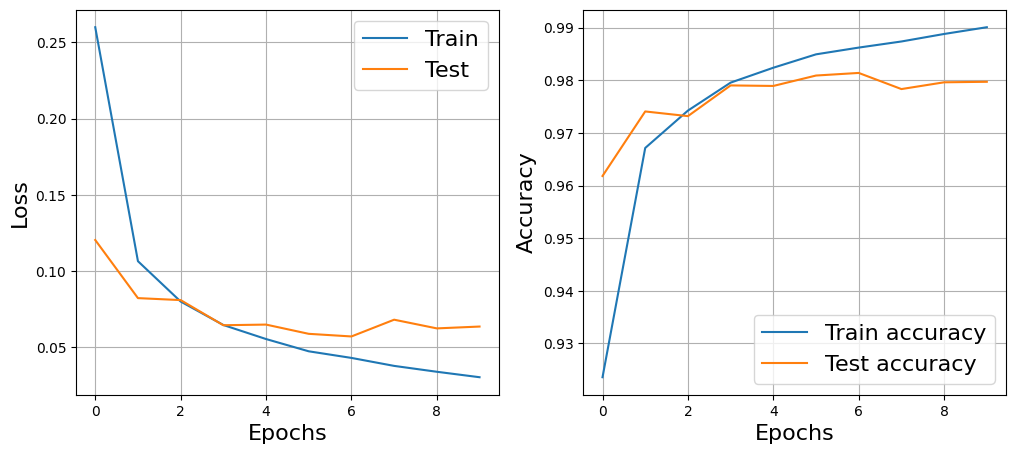

In [21]:
layers = nn.Sequential(
    nn.Linear(196, 128),
    nn.ReLU(), nn.BatchNorm1d(128),
    nn.Linear(128, 128),
    nn.ReLU(), nn.BatchNorm1d(128),
    nn.Linear(128, 10),
)

network = TestNetwork(layers)

train_loss_3, test_loss_3, train_score_3, test_score_3 = train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.025/0.065	Accuracy: 0.992/0.980


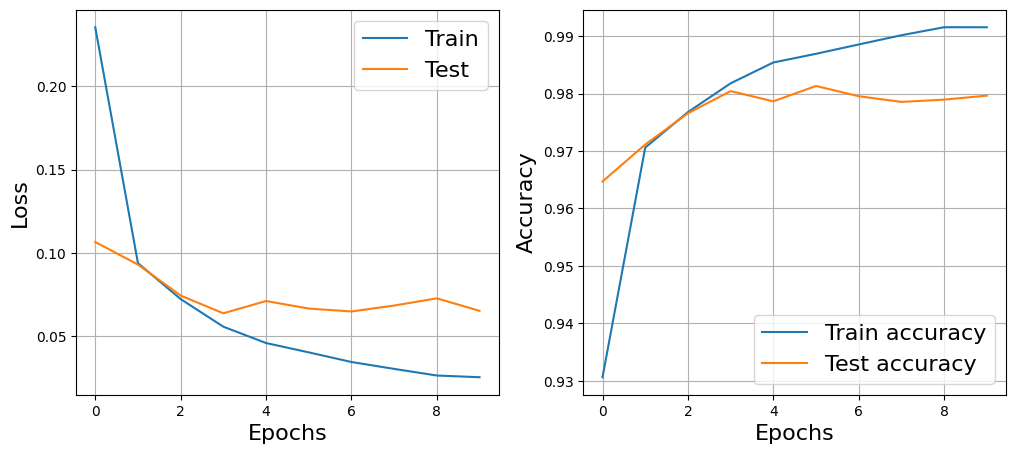

In [22]:
layers = nn.Sequential(
    nn.Linear(196, 128),
    nn.ReLU(), LayerNormalization(128),
    nn.Linear(128, 128),
    nn.ReLU(), LayerNormalization(128),
    nn.Linear(128, 10),
)

network = TestNetwork(layers)

train_loss_4, test_loss_4, train_score_4, test_score_4 = train(network, train_loader, test_loader, 10, 0.001, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

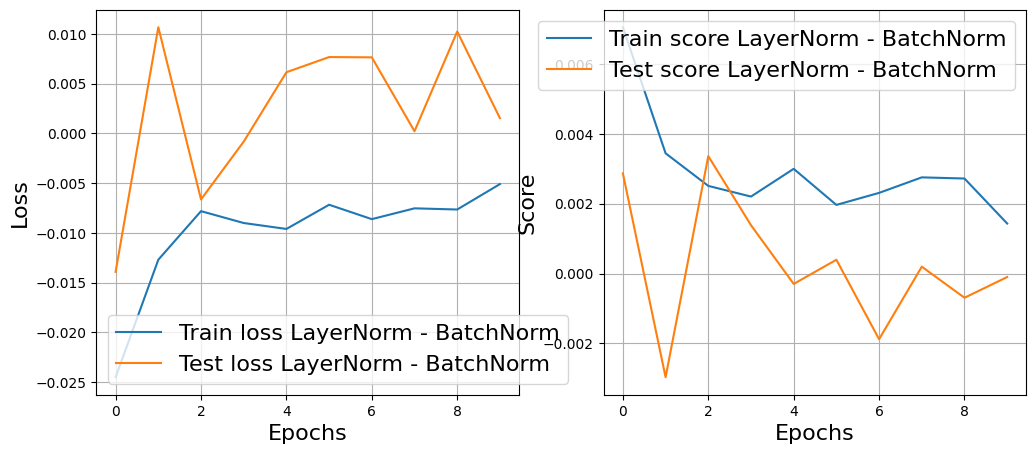

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.array(train_loss_4) - np.array(train_loss_3), label='Train loss LayerNorm - BatchNorm')
plt.plot(np.array(test_loss_4) - np.array(test_loss_3), label='Test loss LayerNorm - BatchNorm')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.array(train_score_4) - np.array(train_score_3), label='Train score LayerNorm - BatchNorm')
plt.plot(np.array(test_score_4) - np.array(test_score_3), label='Test score LayerNorm - BatchNorm')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

$Layer\ Normalization\ vs\ Batch\ Normalization$
* Layer Normalization - Loss : 0.025/0.065, Score : 0.992/0.980
* Batch Normalization - Loss : 0.030/0.064, Score : 0.990/0.980
* Как можно видеть нормализация для каждого объекта более эффективна, чем нормализация по батчу в плане сходимости функционала качества.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

2.3 Сделайте выводы по третьей части.
<br><<<<<<<<br>
2.3 Сделайте выводы по второй части.

Здесь вы можете оставить комментарии по лекции или семинару: